### Hyperparameters and Model Validation

Basic recipe for ML:
1. Choose a class of a model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

**Holdout sets**

We hold some data for training and some for test. We can use <mark> train_test_split </mark> from sklearn to split

**Cross validation**

So we do not lose the data we can train the model by resampling the train and test data. Then take the accuracy scores average to see the global performance of the model
We can use <mark> cross_val_score(model,X,y,cv=no_corss_validations)<\mark> to check scores

**Validation curves**
For linear regression 
Cross-validation to compute validation curves for a class of models

We can generalize to any no of polynomial features. We do this by using a *pipeline* to string the operations together in Scikit-Learn


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
#pipeline for polynomial regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [4]:
# create random data to fit model to 
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

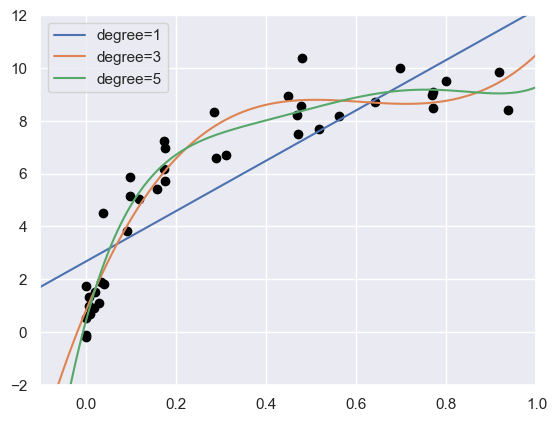

In [5]:
#visualize data and polynomials of degree 1,3,5
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

- model complexity in this case is the degree of the polynomial (which can be any non negative integer)
- Q: what degree of polynomial provides a suitable trade-off between BIAS(under-fitting) and variance(over-fitting)

- answer: use <mark> validation_curve </mark> to compute the training score and validation score across the range

Text(0, 0.5, 'score')

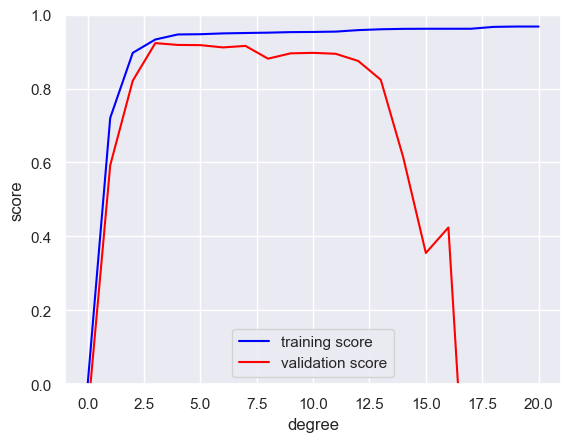

In [12]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree', 
                                          param_range= degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

- the training score is everywhere higher than the validation score
- the training score monotonically increases with model complexity
- validation score reaches a maximum before dropping off as the model becomes over-fit

The optimal tradeoff is where validation score and training curve are closest. in this case polynomial of 3rd degree is best fit

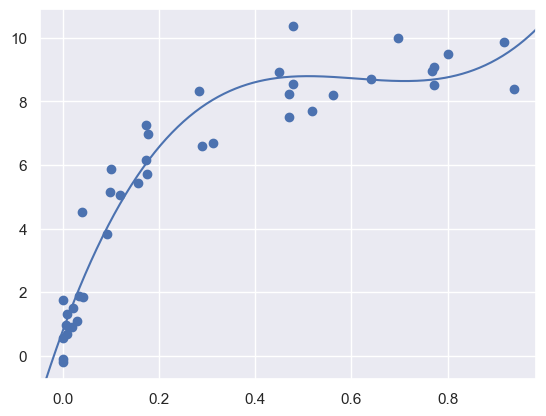

In [13]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Finding the optimal model did not require to compute the training score but examining the relationship between the training score and validation score shows insights on <mark> the performance of the model </mark>

- the larger the dataset the more it can support aa much more complicated model without seriously over-fitting the data
- validation curve behaviour shows two important things: the model complexity, the no of training points
- VERY USEFUL TO explore behaviour of the model on the no of training points
- a plot of the training/validation score with respect to the size of the training set is known as a learning curve

**General behaviour of LEARNING CURVE**
1. A model of a given complexity will overfit a small dataset -> training score will be high while validation score will be low
2. A model of a given complexity will underfit a large dataset: -> training score decreases, but validation score will increase
3. A model will never, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross

! Learning curve converges to a particular score as the no of training samples grows. In particular, once you have enough points that a particular model has converged, *adding more training data* does not help.!
<mark> ONLY WAY to increase performance is to use another (more complex) model</mark>

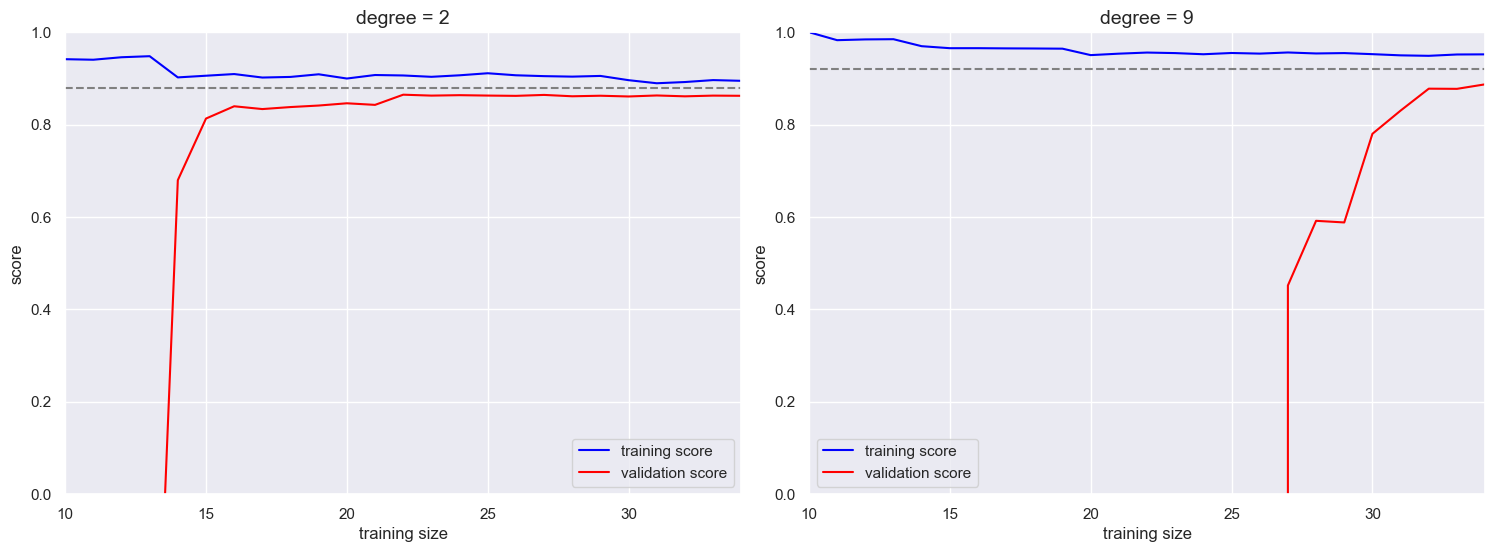

In [15]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Above , dashed line is learning curve for model of 2degree polynomial and 9degree.

- first picture shows convergence (training curve and validation curve super close)
- second picture shows increase in the score of covergence but at the expense of higher model variance

##### Validation in Practice: GRID SEARCH ####

Bc models can be complex the validation can become multidimensional and complicated, thus we would rather simply find the particular model that maximisez the validation score
To do so we use <mark> GridSearchVB </mark> from scikit-learn

the following examples explores a three-dimensional grid of model features: polynomial degree, the flag telling us if we should fit the intercept, the flag tellign wheter to normalize the problem

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}
# cv Determines the cross-validation splitting strategy., so here we want 7 no of folds
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [18]:
grid.fit(X, y)

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline i

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [19]:
grid.fit(X, y);

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline i

In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


(-0.04687651021505175,
 0.9844070023112612,
 -0.7308177116555796,
 10.902869392322714)

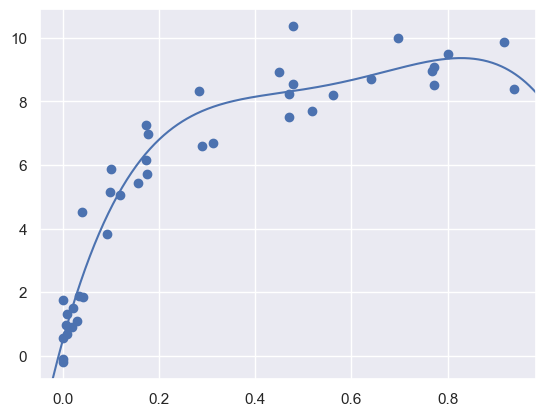

In [23]:
# so best model is polynomial 4, normalized and without fitting the intercept 
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)